## Key Takeaways
* ETF investors appear to be consistently bad at timing their purchases and sales.  In aggregate, they tend to "buy high and sell low".  
* We can measure impact of investor timing using data on net creation/redemptions of ETF shares.
* The average _investor's_ return tends to lag the _investment's_ return by between 1 and 4+% percent per year.  
* For example, investors in SPY generated 13.6% annualized return during an 8 year period when SPY returned 15.2%, a difference of 1.6% per year.
* This impact, often called the "behavior gap", is most significant for industry sector funds and country funds.
* Investors can avoid being negatively impacted by this effect by not following the herd.  Contrarians can use inflows as a bearish signal and outflows as a bullish signal.  

## Introduction
<p style="text-align: center;"> <i>"We have met the enemy, and he is us"</i> - Walt Kelly </p>

It has long been noted that investors - individual and institutional alike - tend to be their own worst enemies.  They have an uncanny ability to buy stocks near market tops and sell near market bottoms.  It's probably more accurate to reverse this implied causality.  Markets top _because_ the last investor in the herd has piled in, and markets bottom _because_ the laggards of the herd has exited.  But I digress...

As a consequence, _investor returns_, in aggregate, have a tendency to significantly lag _investment returns_ in aggregate since fewer dollars are in the market to participate on the way up than on the way down.  

Back in 1994, a research firm named DALBAR made a name for themselves by attempting to quantify the gap between investor returns and investment returns, which they termed the "behavior gap".  To do this, they used data from the Investment Company Institute (ICI) to track inflows and outflows of investor capital to mutual funds so they could estimate money-weighted rates of return, or how much an average _investor_ within any given investment was likely to perform.  

Results were jaw dropping.  DALBAR estimated the "behavior gap" to be more than 4% per year, meaning that the average investor earned less than _half_ of the returns of the investments they held.  The firm has continued to update this study annually.  You can read the most recent annual update to DALBAR's report [here in the Quantitative Analysis of Investor Behavior report](https://2wmko64dug4x3dv4oh97ijl9-wpengine.netdna-ssl.com/wp-content/uploads/2018/04/2018-QAIB-Report_FINAL.pdf).  

A number of major flaws in the DALBAR methodology [have been pointed out](https://www.kitces.com/blog/does-the-dalbar-study-grossly-overstate-the-behavior-gap-guest-post/).  Without wading too far into this debate, I do believe that the critics make a strong case that the methodology is structurally flawed.  

In this post, I'm going to attempt to replicate these results using a somewhat different methodology. Using __daily__ fund flows data on major ETFs, I will establish a straightforward and transparent framework to estimate behavior gap in a way that fixes some of the major problems with DALBAR.  Then, I'll use this framework to estimate the behavior gap in leading ETFs from different asset classes and styles to draw some conclusions about the "behavior gap" that exists within ETF investors.  

As usual, I will share the code used to execute this analysis in the interest of transparency and education.  If you'd like to experiment with the code, _you can download the source notebook for this post by right-clicking on the below button and choosing "save link as"_ 

<a style="text-align: center;" href="https://github.com/convergenceIM/alpha-scientist/blob/master/content/investor_flows.ipynb"><img src="images/button_ipynb-notebook.png" title="download ipynb" /></a>

_Note that a few lines of this code call on my proprietary price data libraries so you'll need to replace with connections to your datafeed of choice._  

### About Fund Flows
A quick word about the ETF fund flow data on which this work is based:  

Unlike most other securities, ETFs are continuously being created and redeemed in response to investor demand, via "authorized participant" intermediaries.  ETF sponsors (iShares, Vanguard, etc...) publish daily several values other than closing market price, including net asset value, total cash, and shares outstanding.

"Shares outstanding" is of particular interest to us.  As the name implies, it reflects the total number of shares in the market at any given time.  Unlike common stocks, which tend to have rather stable shares outstanding, ETF share counts are changing virtually every day.  

By tracking day to day changes in shares outstanding, we can calculate the net number of shares created or destroyed.  This value, when normalized by total shares available, yields a percent of net inflow/outflow in the fund.  If fund ABC closed on Monday with 10,000,000 shares outstanding and closed on Tuesday with 10,500,000 outstanding then 500,000 shares were created, or 5% of the fund's value.  This is analagous to ICI "fund flows", except that it can be calculated once per day.

I've found [this article](https://www.fidelity.com/learning-center/investment-products/etf/primer-on-etf-valuation) a useful overview of the mechanics of ETFs and description of data types unique to ETFs.  

## Step 1: Load Data
OK, onto the analysis.  First, I'll define the functions needed to load and split/dividend adjust the ETF price data, as well as the daily shares outstanding data (aka "SO").  This shares outstanding data is critical because it allows us to infer the daily capital flows into or out of the funds.  

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

### Proprietary libraries
import sys
sys.path.append('/anaconda2/') # either place your config.py in this path, or add another sys.path.append() pointing to your path for config.py
import config ## TODO: place file called config.py in the /anaconda2/ folder

sys.path.append(config.REPO_ROOT+'data/') #Chad: Home
from prices.eod import iqfeed
from prices.eod.read import get_adjustment_factors

## Function to load prices and adjust dividends
def make_data(symbols,begin_date='2009-01-01',end_date='2017-12-31'):
    
    price = iqfeed.read_etf_daily(symbols)
    so = iqfeed.read_etf_so(symbols) # shares outstanding
    df = price[['close']].join(so)
    df.loc[df.so==0,'so'] = None
    df.so = df.so.ffill() # handle days of unreported shares out 
    df = df[df.so>0]
    
    # adjust data for splits and dividends
    adj_factors = get_adjustment_factors(symbols).stack()
    adj_factors.name = 'adj_factors'
    df['close_adj'] = df.close * adj_factors
    df['daily_ret_adj'] = df.close_adj.groupby(level='symbol').pct_change()
    df['log_ret_adj'] = np.log(df.close_adj).groupby(level='symbol').diff()
    df['flow'] = np.log(df.so).groupby(level='symbol').diff()
    df['mkt_cap_adj'] = df.so*df.close_adj

    # catch outliers
    df = df[df.daily_ret_adj.abs()<0.25] # daily price changes of >25%
    df = df[df.so.pct_change().abs()<0.50] # shares outstanding change of >50%

    # standardize time frame
    df = df.xs(slice(begin_date,end_date),level='date',drop_level=False)
    
    return df.copy()

df = make_data(['SPY'])
print(df.tail())


                    close            so   close_adj  daily_ret_adj  \
date       symbol                                                    
2017-12-22 SPY     267.51  1.030182e+09  265.251805      -0.000262   
2017-12-26 SPY     267.19  1.036982e+09  264.934506      -0.001196   
2017-12-27 SPY     267.32  1.043082e+09  265.063409       0.000487   
2017-12-28 SPY     267.87  1.047082e+09  265.608766       0.002057   
2017-12-29 SPY     266.86  1.043032e+09  264.607292      -0.003770   

                   log_ret_adj      flow   mkt_cap_adj  
date       symbol                                       
2017-12-22 SPY       -0.000262 -0.007254  2.732577e+11  
2017-12-26 SPY       -0.001197  0.006579  2.747324e+11  
2017-12-27 SPY        0.000486  0.005865  2.764829e+11  
2017-12-28 SPY        0.002055  0.003827  2.781142e+11  
2017-12-29 SPY       -0.003778 -0.003875  2.759939e+11  


Note that fund flows are, in theory, independent from fund returns.  Net creations or redemptions do not directly impact share price or investor returns.  Below, for example, is the share count and price for XLE at each daily close from 2011 to 2017.  

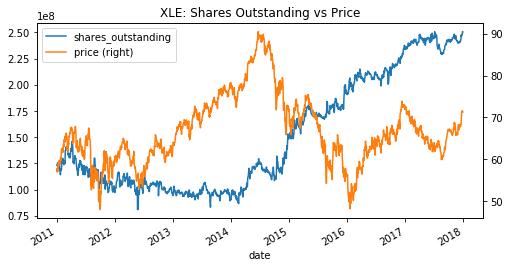

In [2]:
# Example: Shares Outstanding 
symbol = 'XLE'
df = make_data([symbol])
df.xs(symbol,level='symbol')['2011':].so.rename('shares_outstanding').plot(figsize=(10,4),legend=True)
df.xs(symbol,level='symbol')['2011':].close_adj.rename('price').plot(title='{}: Shares Outstanding vs Price'.format(symbol),figsize=(8,4),legend=True,secondary_y=True, )

In [3]:
# Distribution of daily changes 
(df.xs(symbol,level='symbol')['2011':].flow*100.).rename(symbol).plot.hist(bins=61,
title='{}: Daily Change in Shares (%)'.format(symbol),figsize=10,4),xlim=(-10,10),alpha=0.75)

SyntaxError: invalid syntax (<ipython-input-3-2211351371e6>, line 3)

## Step 2: Define the return formulas

Next, I'll define the formulas for "investment return" (i.e., time-weighted) and "investor return" (i.e., money-weighted).  

`calc_investment_return` is straight forward.  `calc_investor_return` is a bit more involved.  First, flows are normalized to the market capitalization at the beginning of the period (day 0), which we'll use as our base currency.  Then, we will simulate a hypothetical investor who contributes and redeems capital exactly in proportion to the market as a whole.  This hypothetical investor's `basis` (i.e., cost basis) is calculated.   

To simplify the math, I calculate `avg_daily_log_ret` as the average of daily log returns _weighted_ by capital employed (normalized by capital employed).  In other words, if the example investor started with 100 dollars of capital and contributed 10 each day for the next 10 days, the return they earned on the last day would be much more important than the return earned on the first day, since there would be considerably more capital invested on day 10 than day 1. 

The precisely correct way to calculate money-weighted return is to use an IRR formula.  However, solving that formula for a 500, 1000, or 1500 period time series is computationally non-trivial (it requires solving a polynomial of the order 500 or 1000 or 1500...)  I believe this method gives a quite close approximation.  Case in point, if we were to force the `df['flow']` column to equal zero we get identical returns for investor and investment - exactly as expected.  

Note that both calculations are based on the _dividend adjusted_, _net of fees_ returns so none of the difference between methods is attributable to fund costs or dividends.


In [ ]:
## Time-Weighted Return (aka Investment Return)
# Calculate average daily log return, annualize assuming 252 day year
# convert to simple returns

def calc_investment_return(df):
    avg_daily_ret_log = (df.log_ret_adj).mean() 
    annual_ret_log = avg_daily_ret_log*252
    annual_ret_simple = np.exp(annual_ret_log)-1
    return annual_ret_simple*100

def calc_investor_return(df):
    ''' Calculate the return for the full time period normalized for amount of capital deployed.
    '''
    # First, calculate the invested "basis" in terms of day 0 dollars.      
    adj_flows = df.flow*(df.mkt_cap_adj/df.mkt_cap_adj.iloc[0]) 
    adj_flows.iloc[0] = 1 # initial principal
    basis = (adj_flows).cumsum() #cumulative contributions in beginning of period dollars

    # Adjust each day's returns 
    ## HERE'S THE MAGIC:
    avg_daily_log_ret = (df.log_ret_adj*basis / basis.mean()).mean()
    avg_annual_log_ret = avg_daily_log_ret*252
    avg_annual_simple_ret = np.exp(avg_annual_log_ret)-1
    
    return avg_annual_simple_ret*100

def compare_annual(df):
    symbols = df.index.get_level_values('symbol').unique().tolist()
    
    out = pd.DataFrame()
    for symbol in symbols:
        twr = df.xs(symbol,level='symbol').resample('A').apply(calc_investment_return)
        twr.name = 'twr'
        mwr = df.xs(symbol,level='symbol').resample('A').apply(calc_investor_return)
        mwr.name = 'mwr'
        days_in_year = df.xs(symbol,level='symbol').log_ret_adj.dropna().resample('A').count()
        
        both = pd.concat([twr,mwr],axis=1).reset_index().iloc[1:]

        both['symbol'] = symbol
        both.set_index(['date','symbol'],inplace=True)
        both['timing_impact'] = both.mwr - both.twr
        out = pd.concat([out,both],axis=0)
    return out

## Step 3: Apply to ETF Data
Now that we have the formulas defined, we'll start by applying to various groupings of ETFs - beginning with four major equity index ETFs.  For each, we'll calculate an annualized return for the investment (time-weighted) and annualized reutrn for investors (money-weighted), then difference these two values into the column `results['behavior_gap']`.  

A positive `behavior gap` means that investors, on average, actually beat the index by being more heavily allocated during upswings than declines.  

In [ ]:
symbols = ['SPY','IWM','QQQ','VT']


df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

Here, we see significant behavior gaps for all funds, with possible exception of Vanguard Total World Index (VT).  Taking SPY as an example, the fund's annualized rate of return (net of fees, including dividends) was 15.17%.  However, the aggregate return of investors in SPY was 13.59%, a -1.58% difference!  

We can drill into this data by measuring each year's behavior gap.  In other words, the amount that investors, in aggregate, over/underperformed the fund's performance due to timing of inflows and outflows _within that year_.  

In [ ]:
# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)

The negative behavior gap is fairly consistent, even when looking at the impact of flows _within_ a single year. This is, in my opinion, an important validation check which addresses [the major criticism](https://www.kitces.com/blog/does-the-dalbar-study-grossly-overstate-the-behavior-gap-guest-post/) of the DALBAR methodology: that it's skewed by long term trends in market returns.  

The astute observer will notice that the overall behavior gap is considerably higher than the average of the years.  For instance, SPY has an annualized behavior gap of -1.58% overall but no single year had a gap this wide.  Why? Because the by-year calculations only consider the flow of funds _within_ a given year, not across years.  

The one notable exception among this group of equity index ETFs is VT, the Vanguard Total World Stock Index.  Vanguard has the reputation for attracting buy-and-hold types, and the Total World Stock Index may be the most buy-and-hold-y of them all.  

Below is a chart of the average absolute daily fund flows (as a percent of fund value) for VT and SPY.  The main takeaway is that Vanguard investors aren't _better_ at timing the market, they're better at _not timing the market_!  

In [ ]:
vt_daily_flow_abs = df.xs('VT',level='symbol').flow['2011':].abs().rename('VT') *100
spy_daily_flow_abs = df.xs('SPY',level='symbol').flow['2011':].abs().rename('SPY') *100

title = 'Mean Absolute Daily Fund Flows (%)'
vt_daily_flow_abs.resample('BM').mean().plot(legend=True,title=title)
spy_daily_flow_abs.resample('BM').mean().plot(legend=True)


### Industry Sector
With the largest broad-market index funds as a reference, I'm interested in other groupings of funds

It's not uncommon for active investors to "rotate" between sectors based on perceived value or economic cycle.  Here, it appears that investor timing is much more problematic.  Sectors have, on average, a much larger behavior gap of -1.09%.  

In [ ]:
symbols = ['XLY','XLK','XLB','XLE','XLV','XLU','XLI','XLP']

df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)


The behavior gap really intensifies when looking at sector funds, with an average annualized gap of almost 3.4% across funds.  

XLE, for instance, shows a behavior gap of more than 5% per year, reaching the ballpark of DALBAR's extraordinary finding.  This effect is entirely driven by year-to-year differences in funds.  As the chart below shows, cash poured into the sector in 2014, just as sector performance tanked.  

In [ ]:
symbol = 'XLE'
(df.xs(symbol,level='symbol').log_ret_adj.resample('A').sum()*100).plot(legend=True,color='b',\
title='{}: Yearly Net Flows vs. Yearly Returns'.format(symbol))
(df.xs(symbol,level='symbol').flow.resample('A').sum()*100).cumsum().plot(legend=True,color='g')

plt.axhline(y=0.000,color='grey',ls='--')


Similar to sector funds, country/regional fund investors appear to be gifted for mis-timing markets.  As is often the case, the trade which "feels right", isn't.  


In [ ]:
symbols = ['EWA','EWG','EWJ','EWC','FXI','EEM']

df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)


Finally, I'll test the major bond ETFs.  Investor behavior strikes again!  TLT (20+ year US treasury) is the notable exception to the rule, with investor returns meaningfully exceeding investment returns.  This is true despite the fact that TLT is among the highest inflow/outflow funds tested (almost 2x the rate of SPY).  

Perhaps bond investors truly are the "smart money"! 

In [ ]:
symbols = ['AGG','TLT','IEF','MUB','JNK','LQD']

df = make_data(symbols)

results = pd.DataFrame(columns=['investment','investor'])
for symbol in symbols:
    #tmp = df.xs(slice('2014-01-01','2016-12-31'),level='date',drop_level=False).xs(symbol,level='symbol',drop_level=True)
    try:
        tmp = df.xs(symbol,level='symbol',drop_level=True)
        results.loc[symbol,'investment'] = calc_investment_return(tmp)
        results.loc[symbol,'investor'] = calc_investor_return(tmp)
    except:
        print("Failed at: {}".format(symbol))

results['behavior_gap'] = results.investor - results.investment
print(results.sort_index())

# plot by year
by_year = compare_annual(df).timing_impact.unstack().round(3)
by_year.index = by_year.index.year
title = '"Behavior Gap" By Fund (%)\nWithin year'
sns.heatmap(by_year,center =0.00, cmap = sns.diverging_palette(10, 220, sep=1, n=21),annot=True)
plt.title(title)


### Summary

I began this post as a counterpoint to DALBAR's shocking results and questionable methodology.  After running the analysis, however, I've found evidence of a shockingly large and consistent behavior gap for ETF investors.  

The most basic takeaway of this analysis is "Don't follow the herd".  The popular trade is, more often than not, the wrong trade.  This appears to be true with regard to overall market timing (risk-on, risk-off) and especially true of sector and asset class rotation strategies.  

Contrarians can take this as an invitation to time the market, _against the flow of market sentiment_.  It's  easier said than done to buy an asset class when everyone is certain that it is doomed.  Yet, those who can do this are rewarded.

For those curious about how this signal is playing out in today's marekts, below are the recent (past ~12 weeks) net fund flows for the ETFs used in this post.  Treasury funds (TLT, IEF), along with Consumer Staples (XLP), Municipals (MUB) and China Large Cap (FXI) have all seen significant inflows as of late - a possible warning sign.  

Interational equities (EEM, EWJ, EWG, EWA) and materials (XLB) have seen heavy outflows in the past few months, a possible buy signal.

In [ ]:
all_symbols = ['SPY','IWM','QQQ','VT','AGG','TLT','IEF','MUB',\
               'JNK','LQD','EWA','EWG','EWJ','EWC','FXI','EEM',\
               'XLY','XLK','XLB','XLE','XLV','XLU','XLI','XLP']

df = make_data(all_symbols,begin_date='2018-06-01',end_date='2018-08-21')

colors = ['green']*5+['grey']*14+['red']*5

df.flow.groupby(level='symbol').sum().sort_values()\
.plot.barh(color=colors,figsize=(8,6),\
           title='Net Flows by Fund\n2018-06-01 to 2018-08-21')

### One last thing...
If you've found this post helpful, please consider subscribing to the email list to be notified of future posts (email addresses will only be used for this purpose...).  

You can also follow me on [twitter](https://twitter.com/data2alpha) and forward to a friend or colleague who may find this topic interesting.  